# Case study: Ring-hydroxylating Dioxygenases

# Table of Contents

* [protlearn](#protlearn)
  * [MSA](#protlearn.MSA)
    * [\_\_init\_\_](#protlearn.MSA.__init__)
    * [map\_positions](#protlearn.MSA.map_positions)
    * [cleanse](#protlearn.MSA.cleanse)
    * [reduce](#protlearn.MSA.reduce)
    * [cluster\_sequences](#protlearn.MSA.cluster_sequences)
    * [generate\_wordclouds](#protlearn.MSA.generate_wordclouds)
    * [select\_features](#protlearn.MSA.select_features)
    * [select\_residues](#protlearn.MSA.select_residues)
    * [generate\_logos](#protlearn.MSA.generate_logos)
* [Manual Steps](#manual_steps)  <!-- Add this line to link to the manual section -->


<a id="protlearn"></a>

# protlearn

Protlearn is a module that applies Machine Learning techniques to extract meaningful information from
Multiple Sequence Alignments (MSA) of homologous protein families.

Copyright (C) 2023, Lucas Carrijo de Oliveira (lucas@ebi.ac.uk)

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.


In [1]:
from protlearn import *


<a id="protlearn.MSA"></a>
## MSA Objects

```python
class MSA(pd.DataFrame)
```

A class for processing and analyzing Multiple Sequence Alignments (MSA).

<a id="protlearn.MSA.__init__"></a>

#### \_\_init\_\_

```python
def __init__(self, msa_file, msa_format="fasta", *args, **kwargs)
```

Initialize the MSA object.

**Arguments**:

- `msa_file` _str_ - The path to the MSA file.
- `msa_format` _str, optional_ - The format of the MSA file (default is "fasta").
- `*args` - Additional positional arguments to pass to SeqIO.parse.
- `**kwargs` - Additional keyword arguments to pass to SeqIO.parse.


In [2]:
# Create a dummy class `Args` that pretends to be `argparse` so `args` works in this Jupyter notebook.
class Args:
    def __init__(self):
        self.data = "pf00848-alignment.fasta"
        self.metadata = "pf00848-metadata.tsv"
        self.plot_methods = ['cleanse', 'reduce', 'cluster_sequences', 'select_residues'] 
        self.save = True   # Set to True or False as needed
        self.show = True    # Set to True or False as needed
        self.export = "./output/pf00848.pkl"
# Create an instance of the Args class
args = Args()
# Create data frame from raw data and clean it
msa = MSA(args.data)
n_rows, n_columns = msa.shape
print(f"Data from {args.data} contains {n_rows} sequences and {n_columns} columns")

Data from pf00848-alignment.fasta contains 9381 sequences and 1225 columns



<a id="protlearn.MSA.map_positions"></a>
#### map\_positions

```python
def map_positions()
```

Map residue positions in the Multiple Sequence Alignment (MSA) based on sequence headers.

This method calculates the position of each residue in the MSA sequences and stores
the mapping in the 'positions_map' attribute of the MSA object. The mapping is
based on the sequence headers, which typically include information about the
sequence's starting position.

The 'positions_map' is a dictionary with sequence headers as keys and a sub-dictionary
as values. The sub-dictionary contains MSA columns (keys) and their corresponding
positions (values).

For example:
{
    'Seq1/1-100': {21: 1, 25: 2, ...},
    'Seq2/171-432': {101: 171, 103: 172, ...},
    ...
}

This mapping is useful for downstream analysis that requires knowing the position
of residues in the MSA.

**Notes**:

  - Residues represented by '-' (indels/gaps) are not included in the mapping.


**Example**:

  msa = MSA()
  msa.parse_msa_file('example.fasta')
  msa.map_positions()

  Access the mapping:
  positions = msa.positions_map


In [3]:
msa.map_positions()


<a id="protlearn.MSA.cleanse"></a>
#### cleanse\_data

```python
def cleanse(indel='-', remove_lowercase=True, threshold=.9, plot=False, save=False, show=False)
```

Cleanse the MSA data by removing columns and rows with missing values.

**Arguments**:

- `indel` _str, optional_ - The character representing gaps/indels (default is '-').
- `remove_lowercase` _bool, optional_ - Whether to remove lowercase characters (default is True).
- `threshold` _float, optional_ - The threshold for missing values (default is 0.9).
- `plot` _bool, optional_ - Whether to plot a heatmap of missing values (default is False).


self.dirty.shape after replacing specified characters with NaN: (9381, 1225)
self.clean.shape right after creating a copy of 'dirty' data as the 'clean' data: (9381, 1225)
min_rows: 8442
self.clean.shape after removing columns with NaN values above the threshold: (9381, 41)
self.clean.shape after removing rows with NaN values above the threshold: (7568, 41)


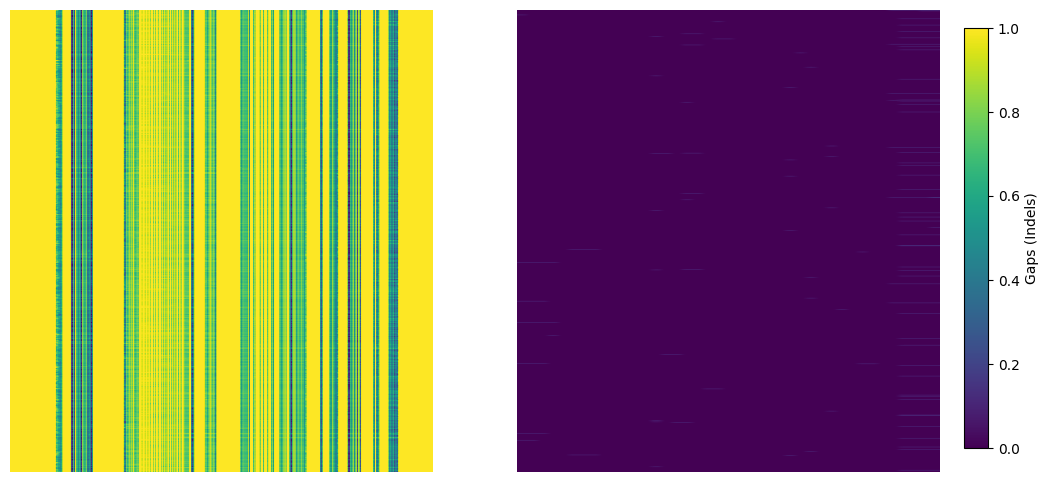

Before removing null values: (9381, 1225)
After removing null values: (7568, 41)
After removing duplicates: (6469, 41)


In [4]:
msa.cleanse(plot=True, show=True)
print(f"Before removing null values: {msa.dirty.shape}")
print(f"After removing null values: {msa.clean.shape}")
print(f"After removing duplicates: {msa.unique_sequences.shape}")


<a id="protlearn.MSA.reduce"></a>
#### reduce

```python
def reduce(plot=False, *args, **kwargs)
```

Perform Multidimensional Correspondence Analysis (MCA) on the MSA data to reduce dimensionality.

**Arguments**:

- `plot` _bool, optional_ - Whether to plot the results (default is False).
  *args, **kwargs: Additional arguments and keyword arguments for the MCA.


**Notes**:

  - Multidimensional Correspondence Analysis (MCA) is used to reduce the dimensionality of the MSA data.
  - The MCA results are stored in the 'analysis' attribute of the MSA object.
  - The row coordinates after reduction are stored in the 'coordinates' attribute.


**Example**:

  msa = MSA('example.fasta')
  msa.map_positions()
  msa.cleanse()
  msa.reduce(plot=True)

In [5]:
msa.reduce(n_components=2, plot=True)
print(f"Dimensions reduced from {msa.unique_sequences.shape} to {msa.coordinates.shape}")

Dimensions reduced from (6469, 41) to (6469, 2)



<a id="protlearn.MSA.cluster_sequences"></a>
#### label\_sequences

```python
def cluster_sequences(min_clusters=2,
                    max_clusters=10,
                    method='single-linkage',
                    plot=False, save=False, show=False)
```

Cluster the MSA data and obtain cluster labels.

**Arguments**:

- `min_clusters` _int, optional_ - Minimum number of clusters (default is 2).
- `max_clusters` _int, optional_ - Maximum number of clusters (default is 10).
- `method` _str, optional_ - Clustering method ('k-means' or 'single-linkage') (default is 'single-linkage').
- `plot` _bool, optional_ - Whether to plot the clustering results (default is False).


**Notes**:

  - This method performs clustering on the MSA data and assigns cluster labels to sequences.
  - Clustering can be done using either k-means or single-linkage methods.
  - The optimal number of clusters is determined using silhouette scores.
  - The cluster labels are stored in the 'labels' attribute of the MSA object.


**Example**:

  msa = MSA('example.fasta')
  msa.map_positions()
  msa.cleanse()
  msa.cluster_sequences(method='single-linkage', min_clusters=3, plot=True)

<a id="protlearn.MSA.generate_wordclouds"></a>

In [6]:
msa.cluster_sequences(method='single-linkage', min_clusters=3)


<a id="protlearn.MSA.select_features"></a>
#### select\_features

```python
def select_features(n_estimators=None, random_state=None, plot=False, save=False, show=False)
```

Select important features (residues) from the MSA data.

**Arguments**:

- `n_estimators` _int, optional_ - Parameter n_estimators for RandomForest.
- `random_state` - (int, optional): Parameter random_state for RandomForest.
- `plot` _bool, optional_ - Whether to plot feature selection results (default is False).

<Figure size 1600x1600 with 0 Axes>

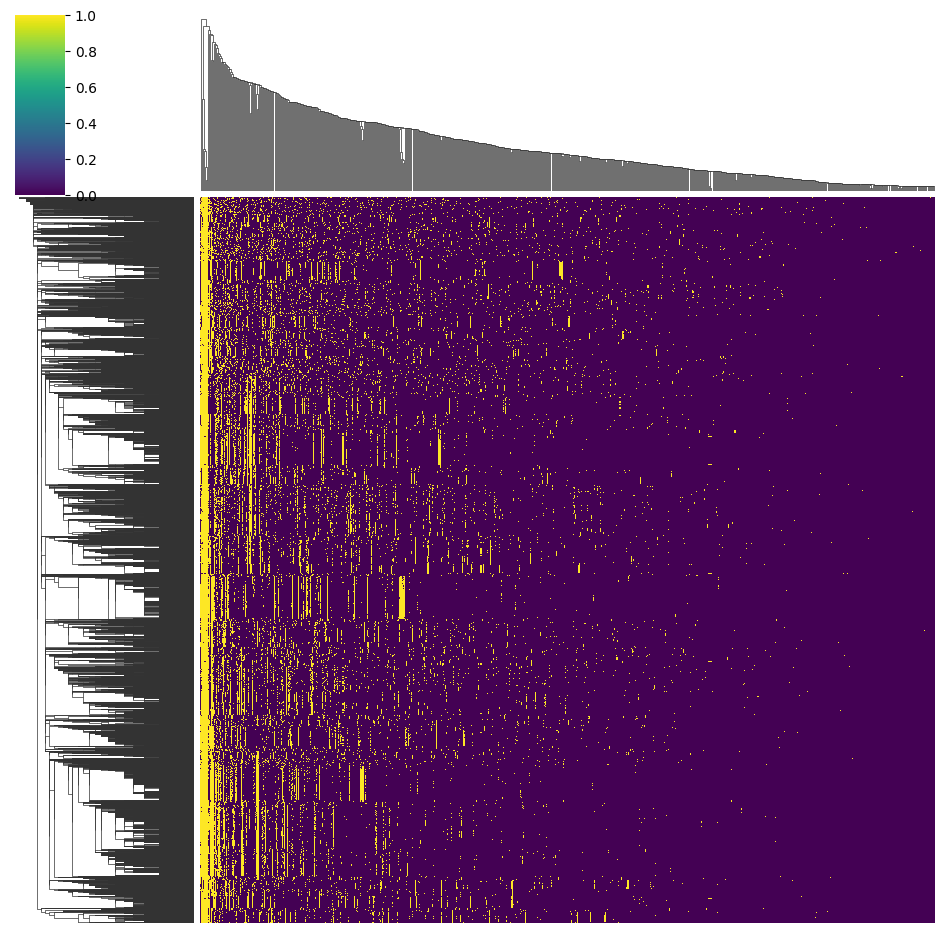

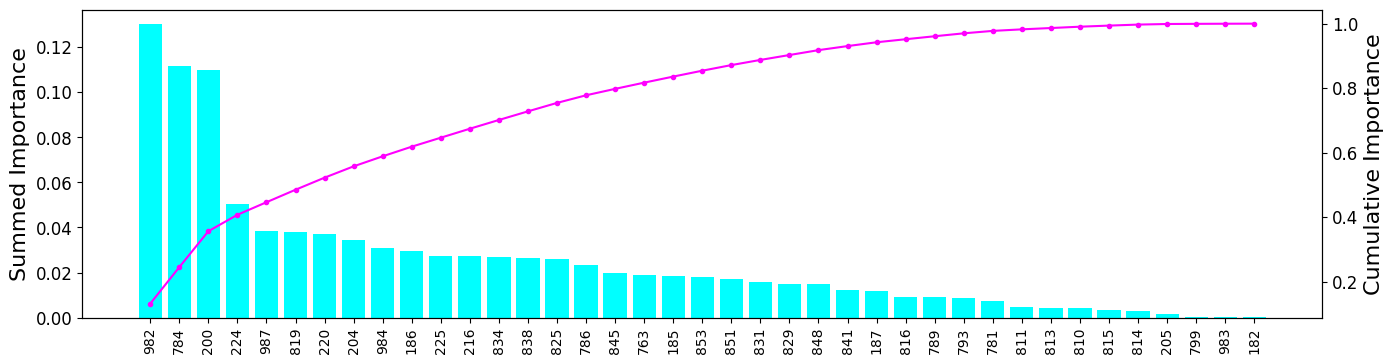

In [7]:
msa.select_features(n_estimators=1000, random_state=42, plot=True, show=True)

<a id="protlearn.MSA.select_residues"></a>

#### select\_residues

```python
def select_residues(threshold=0.9, top_n=None, plot=False, save=False, show=False)
```

Select and store residues to be candidates for Specificity-determining Positions (SDPs) from the MSA data.

**Arguments**:

- `threshold` _float, optional_ - The threshold for selecting residues based on importance (default is 0.9).
- `top_n` _int, optional_ - The top N residues to select based on importance (default is None).
- `plot` _bool, optional_ - Whether to plot the selected residues (default is False).

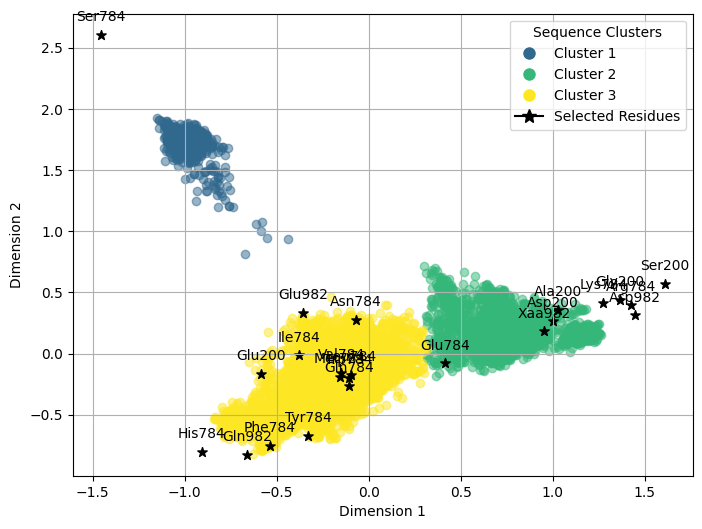

In [9]:
msa.select_residues(top_n=3, plot=True, show=True)

<a id="manual_steps"></a>

### Manual steps:
**Attention!** The following snippets are not implemented in `protlearn` module. From now on, these are manual steps specific to this case study.

<a id="filter-sequences"></a>

### Filter Sequences with Known Structures

The following code snippet filters sequences from the `msa.profiles` DataFrame based on whether their header contains a known structure from the `known_structure` [list](https://www.uniprot.org/uniprotkb?query=pf00848&facets=proteins_with%3A1%2Creviewed%3Atrue). Sequences with headers matching those in the `known_structure` list are retained in the filtered DataFrame.

In [10]:
known_structure = [
    'TPDA2_COMSP',
    'BPHA1_RHOJR',
    'NDOB_PSEU8',
    'NDOB_PSEPU',
    'NAGG_RALSP',
    'CNTA_ACIB2',
    'BNZA_PSEP1',
    'BPHA_PARXL',
    'BPHA_COMTE',
]
have_structure = []

# Iterate through headers and filter sequences with known structures
for header in msa.profiles.index:
    if header.split('/')[0] in known_structure:
        have_structure.append(header)

# Filter and display the sequences with known structures
filtered_sequences = msa.profiles[msa.profiles.index.isin(have_structure)]
filtered_sequences

,200,784,982
BPHA_PARXL/183-451,Ser229,Arg340,Asp387
BPHA1_RHOJR/174-441,Ser220,Arg330,Asp377


<a id="visualize-structure"></a>

### Visualize Protein Structure with Residue Highlights

In the following code, we use the `nglview` library to visualize a protein structure loaded from the Protein Data Bank (PDB). We load the PDB structure with the ID '1ULI,' which corresponds to 'BPHA1_RHOJR/174-441.'

In [11]:
import nglview as nv

# Load the PDB structure with the ID '1ULI' (correspondent to BPHA_PARXL/183-451).
pdb_id = '1ULI'
view = nv.show_pdbid(pdb_id)
view.update_representation(opacity=0.5)

# Define a list of selections for the residues you want to highlight in different chains
sdps, chains = (220, 330, 377), ('A', 'C', 'E')
selection_str = ":{} and ( {} or {} or {} )"

# Iterate over the selections and add representations one at a time
for chain in chains:
#     view.add_surface(selection_str.format(chain, *sdps), color='black')
    view.add_representation('ball+stick', selection=selection_str.format(chain, *sdps), color='black')
    view.add_representation('label', selection=selection_str.format(chain, *sdps), color='red')

# Display the updated structure
view

NGLWidget()